<a href="https://colab.research.google.com/github/prateekgrover-in/Deep_Learning_Practice/blob/master/GANCelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the Celeba Dataset from Google Drive.
CelebA dataset involves more than 200k images of 218*178 resolution. Due to the large size of the dataset (>1GB), the dataset is loaded into Google Drive. The drive is first mounted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Next, we extract the zip file that's been moved to our storage

In [ ]:
import zipfile
import io
zip_ref = zipfile.ZipFile("/content/drive/My Drive/img_align_celeba.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

Moving all the image urls of the faces to an array.

In [ ]:
from glob import glob
faces = list(glob("/content/img_align_celeba/*"))

We clip the input dataset to 2000 images because of limited GPUs, resizing of the image to 96x108 and finally converting them into numpy array of RGB channels.

In [ ]:
from PIL import Image
import numpy as np
from numpy import asarray

x_train = []
for image_url in faces[:200]:
    image = Image.open(image_url)
    resized_image = image.resize([96,108])
    x_train.append(asarray(resized_image))

Converting the python array to a numpy array.

In [ ]:
x_train = np.array(x_train)

We observe that the shape is as required, with 2000 RGB Channel images with dimensions of 96x108.

In [ ]:
x_train.shape

(200, 108, 96, 3)

Normalization of the values of the channel is done to obtain values between -1 to 1.

In [ ]:
x_train = (x_train - 127.5)/ 127.5

Defining the buffer size and batch size for our training.

In [ ]:
BUFFER_SIZE = 200
BATCH_SIZE = 32

We shall be using TensorFlow 2.0 to create the dataset from the numpy array.

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Defining a noise tensor that shall be input to the generator_model.

In [ ]:
generator_noise = tf.random.normal([1, 100], mean = 0.0, stddev = 1.0)

Moving to creating the generator model defined of a deep convolutional neural network.

In [ ]:
generator_model = tf.keras.Sequential()

generator_model.add(layers.Dense(27*24*768, use_bias=False, input_shape=(100,)))
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Reshape((27, 24, 768)))
#assert generator_model.output_shape == (None, 27, 24, 768)

generator_model.add(layers.Conv2DTranspose(384, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#assert generator_model.output_shape == (None, 27, 24, 384)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#assert generator_model.output_shape == (None, 54, 48, 192)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#assert generator_model.output_shape == (None, 108, 96, 3)

Formulating a sample image out of the initialized generator model.

In [ ]:
generated_image = generator_model(generator_noise, training=False)

In [ ]:
(np.array(generated_image[0, :, :, :])*127.5 + 0.5)

array([[[0.45004183, 0.54927063, 0.47061378],
        [0.43650013, 0.55942076, 0.5766545 ],
        [0.47757313, 0.4540193 , 0.52707523],
        ...,
        [0.1515036 , 0.3458874 , 0.6341475 ],
        [0.5224922 , 0.5285673 , 0.48996153],
        [0.4334353 , 0.4770878 , 0.6288826 ]],

       [[0.4620965 , 0.5937007 , 0.5350653 ],
        [0.62107074, 0.2911067 , 0.5879461 ],
        [0.5407944 , 0.45318416, 0.24192593],
        ...,
        [0.5946784 , 0.30158696, 0.5402177 ],
        [0.42522526, 0.6136081 , 0.56093824],
        [0.5805055 , 0.14017558, 0.6370088 ]],

       [[0.45636338, 0.5367574 , 0.59421724],
        [0.39094752, 0.45127377, 0.3085065 ],
        [0.52920896, 0.57599556, 0.4794765 ],
        ...,
        [0.44923255, 0.45496994, 0.8739641 ],
        [0.21176365, 0.546866  , 0.29824173],
        [0.5379716 , 0.6824886 , 0.3779077 ]],

       ...,

       [[0.614255  , 0.48008412, 0.47534767],
        [0.52852905, 0.33256674, 0.5126875 ],
        [0.46559054, 0

Visualizing the output image obtained from a random noise signal.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


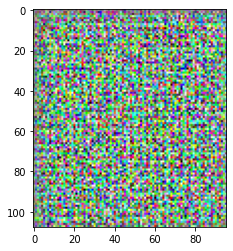

In [ ]:
plt.imshow(np.array(generated_image[0, :, :, :]*127.5 + 0.5))


Defining the discriminator model for the decision making process.

In [ ]:
discriminator_model = tf.keras.Sequential()

discriminator_model.add(layers.Conv2D(108, (5, 5), strides=(2, 2), padding='same', input_shape=[108, 96, 3]))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Conv2D(216, (5, 5), strides=(2, 2), padding='same'))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Flatten())
discriminator_model.add(layers.Dense(1))

The decision tensor, that calculates the similarity between the generated image and actual image

In [ ]:
decision = discriminator_model(generated_image)
print (decision)

tf.Tensor([[-0.00056563]], shape=(1, 1), dtype=float32)


Defining the Binary Cross Entropy loss

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Saving the progress of the model, as it may require long hours

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = tf.keras.optimizers.Adam(1e-4),
                                 discriminator_optimizer = tf.keras.optimizers.Adam(1e-4),
                                 generator=generator_model,
                                 discriminator=discriminator_model)

Defining Hyperparamaters

In [ ]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train(dataset, epochs):

      for epoch in range(epochs):

          start = time.time()

          for image_batch in dataset:
              
              noise = tf.random.normal([BATCH_SIZE, noise_dim])

              with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

                    generated_images = generator_model(generator_noise, training=True)

                    real_output = discriminator_model(image_batch, training=True)
                    fake_output = discriminator_model(generated_images, training=True)

                    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
                    discriminator_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)
              
              generator_gradients = gen_tape.gradient(generator_loss, generator_model.trainable_variables)
              discriminator_gradients = disc_tape.gradient(discriminator_loss, discriminator_model.trainable_variables)

              tf.keras.optimizers.Adam(1e-4).apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
              tf.keras.optimizers.Adam(1e-4).apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))

        # Produce images for the GIF as we go
          display.clear_output(wait = True)
          predictions = generator_model(seed,training=False)

          fig = plt.figure(figsize=(10,10))
        
          for i in range(predictions.shape[0]):
              plt.subplot(2, 2, i+1)
              plt.imshow(np.array(predictions[i, :, :, :] * 127.5 + 127.5).astype(np.uint8))
              plt.axis('off')

          if epoch%150 == 0:
              plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
          plt.show()

          # Save the model every 50 epochs
          if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

          print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
train(train_dataset, EPOCHS)